In [1]:
%load_ext autoreload
%autoreload 2

In [132]:
from qkit.analysis.semiconductor.loaders.Loaderh5 import Loaderh5
from qkit.analysis.semiconductor.analyzers.AnalyzerTimetraceSpectralNoiseDensity import AnalyzerTimetraceSpectralNoiseDensity
from qkit.analysis.semiconductor.plotters.PlotterTimetraceSpectralNoiseDensity import PlotterTimetraceSpectralNoiseDensity
from qkit.analysis.semiconductor.analyzers.AnalyzerPeakTracker_Daniel import AnalyzerPeakTracker
from qkit.analysis.semiconductor.plotters.PlotterPlungerTimetrace3D import PlotterPlungerTimetrace3D
from qkit.analysis.semiconductor.plotters.PlotterPlungerTraceFit import PlotterPlungerTraceFit
from qkit.analysis.semiconductor.plotters.PlotterPlungerTraceTimestampsDifference import PlotterPlungerTraceTimestampsDifference
from qkit.analysis.semiconductor.plotters.PlotterTimetraceJumpsHistogram import PlotterTimetraceJumpsHistogram
from qkit.analysis.semiconductor.main.SlicerPlungerTimetrace import SlicerPlungerTimetrace
from qkit.analysis.semiconductor.loaders.Loader_spectrum_np import Loader_spectrum_np
from qkit.analysis.semiconductor.savers.Saver_spectrum_np import Saver_spectrum_np
from qkit.analysis.semiconductor.savers.Saver_json import Saver_json

import os
import matplotlib.pyplot as plt
from qkit.analysis.semiconductor.analyzers.AnalyzerPeakTracker import Analyzer as Peak_hunt
from qkit.analysis.semiconductor.analyzers.AnalyzerTimetraceJumps  import Analyzer as jump_count
from qkit.analysis.semiconductor.main.fit_functions import gauss_function

# Choose the Data

In [81]:
filepath = "/home/ws/lr1740/Dokumente/Doktorarbeit/Messungen/peak_track/145840_2D_Peak_tracking/145840_2D_Peak_tracking.h5"
savepath = f"{os.path.dirname(filepath)}/analysis"
saver = Saver_json(savepath)
print(savepath)

settings = {"file_info" : {
                "filepath" : filepath,
                "savepath" : savepath,
                "analysis" : "plunger_sweep_timetrace"},
            "meas_params" : {
                "measurement_amp" : 100e-6,
                "voltage_divider" : 3,
                "IVgain" : 1e8,
                "in_line_R": 40e3}
            }

/home/ws/lr1740/Dokumente/Doktorarbeit/Messungen/peak_track/145840_2D_Peak_tracking/analysis


In [82]:
loader = Loaderh5()
data, _ = loader.load(settings)
print(data.keys())

Done loading file, formatting now...
dict_keys(['demod0.r0', 'demod0.timestamp0', 'demod0.x0', 'demod0.y0', 'demod4.r4', 'demod4.timestamp4', 'demod4.x4', 'demod4.y4', 'gates_6_16', 'measurement', 'number', 'settings', 'static_voltages'])


In [83]:
demod_prefix = "demod0"
node_timestamp = f"{demod_prefix}.timestamp0"
node_x = f"{demod_prefix}.x0"
node_y = f"{demod_prefix}.y0"
node_r = f"{demod_prefix}.r0"

gates = "gates_6_16"

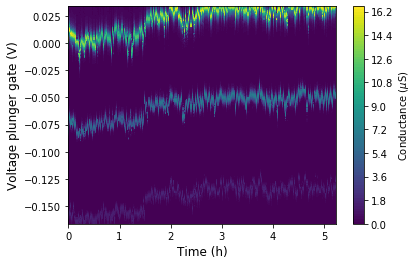

In [84]:
plotter = PlotterPlungerTimetrace3D()
plotter.max_cond = None
plotter.plot(settings, data, [node_timestamp, gates , node_r])

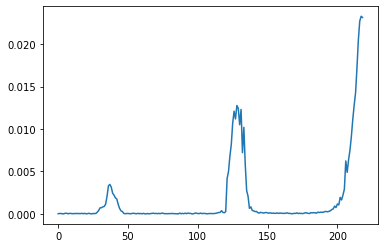

In [85]:
plt.plot(data[node_r][-15])

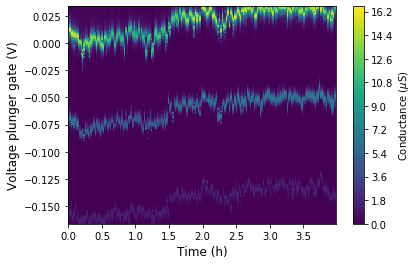

In [86]:
#%% Slice Data and Plot
slicer = SlicerPlungerTimetrace()
slicer.beginning, slicer.ending = 0, 4 # in hours
data_sliced = slicer.slice(data, [node_timestamp, gates , node_r])

plotter = PlotterPlungerTimetrace3D()
plotter.max_cond = None
plotter.savename = "plunger_timetrace_sliced"
plotter.plot(settings, data_sliced, [node_timestamp, gates , node_r])

# Let the peak hunt begin!

## The bloodmoon has risen over the city of Yharnam...

250
2


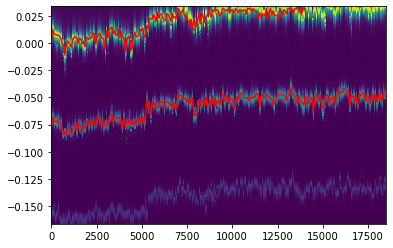

In [101]:
peak_hunter = Peak_hunt(data[node_r], data[node_timestamp], data[gates])
peak_hunter.pf.min_peak_height = 0.005
peak_hunter.pf.min_peak_width = 2
peak_hunter.pf.min_peak_distance = 30
peak_hunter.pf.fit_interval_peak_relheight = 0.9
tracked_peaks = peak_hunter.analyze()
print(len(tracked_peaks["tracked_peak_positions"][0]))
print(len(tracked_peaks["tracked_peak_positions"]))

saver.add_info(f"{node_r}_tracked_peaks", tracked_peaks)

plt.pcolor(tracked_peaks["time_axis"], data[gates], np.transpose(data[node_r]))
for tracked_peak in tracked_peaks["tracked_peak_positions"]:
    length = min([len(tracked_peaks["time_axis"]), len(tracked_peak)])
    plt.plot(tracked_peaks["time_axis"][:length], tracked_peak[:length], color = "r")

# Spectral noise density Calculation

0 124


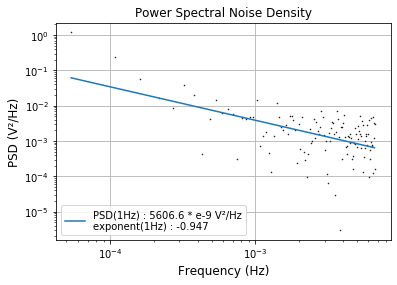

In [102]:
sampling_f = tracked_peaks["time_axis"][1]**-1
peak_no = 0
noise_calculator = AnalyzerTimetraceSpectralNoiseDensity(tracked_peaks["tracked_peak_positions"][peak_no],\
                                                        sampling_f)

noise_calculator.welch_segment_length = 300
noise_calculator.fit_interval = [5e-5, 1e-2]
saver.add_info(f"{node_r}_peak{peak_no}_welch_segment_length", noise_calculator.welch_segment_length)
saver.add_info(f"{node_r}_peak{peak_no}_fit_interval", noise_calculator.fit_interval)

spectral_result = noise_calculator.analyze()
saver.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)

fit = noise_calculator.fit()
saver.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)
saver.save()

f, s = spectral_result["freq"], spectral_result["spectrogram"]
saving_path = os.path.join(settings["file_info"]["savepath"], node_r)

plotter_SND = PlotterTimetraceSpectralNoiseDensity(saving_path, [f,s], fit)
plotter_SND.plot()

# Jump analysis

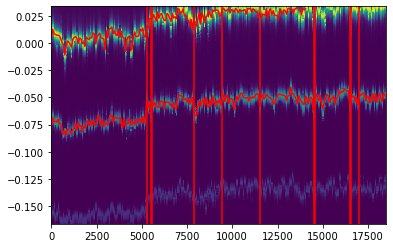

In [134]:
jump_analysis = jump_count(tracked_peaks["tracked_peak_positions"][peak_no], tracked_peaks["time_axis"])
jump_analysis.big_jump_minimum_height = 10e-3
jump_analysis.bin_count = 50
jump_analysis.range = (-0.01, 0.01)
jump_hist, big_jumps = jump_analysis.analyze()
popt = jump_analysis.fit()

plt.pcolor(tracked_peaks["time_axis"], data[gates], np.transpose(data[node_r]))
for tracked_peak in tracked_peaks["tracked_peak_positions"]:
    length = min([len(tracked_peaks["time_axis"]), len(tracked_peak)])
    plt.plot(tracked_peaks["time_axis"][:length], tracked_peak[:length], color = "r")
for jump_time in big_jumps["time_of_big_jumps"]:
    plt.axvline(jump_time, color = "r")

FHWM of the guassian distribution: 11.132976121719945 mV


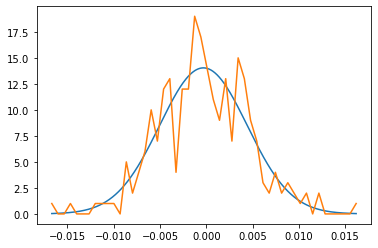

In [140]:
print(f"FHWM of the guassian distribution: {2.35482e3 * popt[-1]} mV")
x = np.linspace(min(jump_hist["jump_height"]), max(jump_hist["jump_height"]), 1000)
y = gauss_function(x, *popt)
plt.plot(x, y)
plt.plot(jump_hist["jump_height"], jump_hist["jumps_per_bin"])